In [83]:
import pandas as pd

In [ ]:
pos_df = pd.read_csv("./datasets/pos_english_text.csv", encoding="latin")
neg_df = pd.read_csv("./datasets/neg_english_text.csv", encoding="latin")
raw_df = pd.concat([pos_df, neg_df])
raw_df

In [ ]:
lab_to_sentiment = {0: "Negative", 4: "Positive"}


def label_decoder(label):
    return lab_to_sentiment[label]


raw_df.sentiment = raw_df.sentiment.apply(lambda x: label_decoder(x))
raw_df

In [ ]:
raw_df.info()

In [ ]:
raw_df.describe()

In [ ]:
raw_df.drop_duplicates(inplace=True)
raw_df.describe().T

In [ ]:
raw_df.groupby(['sentiment']).size().reset_index(name='counts')

In [ ]:
# import matplotlib.pyplot as plt
# val_count = raw_df.sentiment.value_counts()

# plt.figure(figsize=(8,8),facecolor='white')
# plt.pie(val_count.values, labels = val_count.index, autopct='%1.1f%%')
# plt.title("Sentiment Data Distribution")
# plt.show() 

In [ ]:
abbreviations_df = pd.read_csv("./datasets/abbreviations.csv")
apostrophe_df = pd.read_csv("./datasets/apostrophe.csv")
emoji_df = pd.read_csv("./datasets/emoji.csv")
emoticons_df = pd.read_csv("./datasets/emoticons.csv")

In [ ]:
abbreviations_df = abbreviations_df.applymap(
    lambda x: x.casefold() if isinstance(x, str) else x
)
apostrophe_df = apostrophe_df.applymap(
    lambda x: x.casefold() if isinstance(x, str) else x
)
emoticons_df["emoji_name"] = emoticons_df["emoji_name"].apply(
    lambda x: x.casefold() if isinstance(x, str) else x
)
emoji_df = emoji_df.applymap(
    lambda x: x.casefold() if isinstance(x, str) else x
)

In [ ]:
# abbreviations_dict = abbreviations_df.to_dict('dict')
# apostrophe_dict = apostrophe_df.to_dict('dict')
# emoji_dict = emoji_df.to_dict('dict')
# emoticons_dict = emoticons_df.to_dict('dict')
abbreviations_dict = dict(abbreviations_df.values)
apostrophe_dict = dict(apostrophe_df.values)
emoji_dict = dict(emoji_df.values)
emoticons_dict = dict(emoticons_df.values)

In [ ]:
# raw_df = raw_df.sample(10000)

In [ ]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary and word.lower() in text.split():
            text = text.replace(word, dictionary[word.lower()])
    return text

In [ ]:
def translate(input_text):
    from googletrans import Translator
    translator = Translator()
    text = translator.translate(input_text).text
    return str(text)

In [ ]:
def preProcessing(input_text, isSpellCheck=False, isTranslate=False):
    # Step A : Converting html entities i.e. (&lt; &gt; &amp;)
    import html
    text = html.unescape(input_text)
    # Step B : Removing "@user" from all the tweets
    import re
    text = re.sub("@[\w]*", "", text)
    # Step C : Remove http & https links
    text = re.sub("http://\S+|https://\S+", "", text)
    # Translation
    if isTranslate:
        text = translate(text)
    # Step D : Changing all the tweets into lowercase
    text = lookup_dict(text, emoticons_dict)
    # Step G : Emoticon Lookup
    text = lookup_dict(text, emoji_dict)
    # text = text.lower()
    text = text.lower()
    # Step E : Apostrophe Lookup
    text = lookup_dict(text, apostrophe_dict)
    # Step F : Short Word Lookup
    text = lookup_dict(text, abbreviations_dict)
    # Step G : Emoticon Lookup
    # Step H : Replacing Punctuations with space
    text = re.sub(r"[^\w\s]", " ", text)
    # Step I : Replacing Special Characters & Numbers (integers) with space
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # Step J : Spelling Correction - With TextBlob Library
    if isSpellCheck:
        from textblob import TextBlob
        text = str(TextBlob(text).correct())
    # Step K: Remove whitespace
    text = re.sub(r"\s+", " ", text)

    return text

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
raw_df['clear_text'] = raw_df['text'].progress_apply(lambda x: preProcessing(x))
raw_df.head()

In [ ]:
pd.set_option('display.max_colwidth', None)
raw_df[["text", "clear_text"]].sample(20)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize(clean_text):
    tokens = word_tokenize(clean_text)
    stop_words = set(stopwords.words("english"))
    negation_words = [
        "not",
        "never",
        "neither",
        "nor",
        "barely",
        "hardly",
        "scarcely",
        "seldom",
        "rarely",
        "no",
        "nothing",
        "none",
        "nobody",
        "nowhere",
    ]
    return [token for token in tokens if token in negation_words or token not in stop_words]

In [ ]:
raw_df['tokens'] = raw_df['clear_text'].progress_apply(lambda x: tokenize(x))
raw_df.head()

In [ ]:
# from textblob import TextBlob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# def selectPolarity(tokens):
#     analyzer = SentimentIntensityAnalyzer()
#     negation_words = [
#         "not",
#         "never",
#         "neither",
#         "nor",
#         "barely",
#         "hardly",
#         "scarcely",
#         "seldom",
#         "rarely",
#         "no",
#         "nothing",
#         "none",
#         "nobody",
#         "nowhere",
#     ]
#     # return [token for token in tokens if (token in negation_words) or (TextBlob(token).sentiment.polarity != 0)]
#     return [
#         token
#         for token in tokens
#         if (token in negation_words)
#         or (
#             analyzer.polarity_scores(token)["compound"] <= -0.5
#             or analyzer.polarity_scores(token)["compound"] >= 0.5
#         )
#     ]

In [ ]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# def selectPolarity(clear_text):
#     analyzer = SentimentIntensityAnalyzer()
#     # negation_words = [
#     #     "not",
#     #     "never",
#     #     "neither",
#     #     "nor",
#     #     "barely",
#     #     "hardly",
#     #     "scarcely",
#     #     "seldom",
#     #     "rarely",
#     #     "no",
#     #     "nothing",
#     #     "none",
#     #     "nobody",
#     #     "nowhere",
#     # ]
#     # return [token for token in tokens if (token in negation_words) or (TextBlob(token).sentiment.polarity != 0)]
#     # return [
#         # token
#         # for token in tokens
#         # if (token in negation_words)
#         # or (
#         #     analyzer.polarity_scores(token)["compound"] <= -0.5
#         #     or analyzer.polarity_scores(token)["compound"] >= 0.5
#         # )
#     if analyzer.polarity_scores(clear_text)["compound"] <= 0:
#         return "neg"
#     else: 
#         return "pos"
#     # ]

In [ ]:
# raw_df['polarity_tokens'] = raw_df['clear_text'].progress_apply(lambda x: selectPolarity(x))
# raw_df[['clear_text','polarity_tokens']]

In [ ]:
# pd.set_option('display.max_colwidth', None)
# raw_df[['tokens','polarity_tokens']].sample(20)

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    import nltk
    from nltk.corpus import wordnet

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def Lemmatizer(tokens):
    # Importing library for lemmatizing
    from nltk.stem.wordnet import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in tokens]

In [ ]:
raw_df['lemmats'] = raw_df['tokens'].progress_apply(lambda x: Lemmatizer(x))
raw_df.head()

In [ ]:
raw_df.sample(10)

In [ ]:
# df = raw_df[['lemmats','sentiment']]
# del raw_df
# df

In [84]:
df = pd.read_csv("./datasets/tokens.csv")

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    df["lemmats"].apply(lambda x: "".join(x)),
    df["sentiment"],
    test_size=0.3,
    random_state=60,
    shuffle=True,
    stratify=df["sentiment"],
)
X_train

953580     ['sick', 'bad', 'throat', 'bad', 'toothache', ...
231394     ['congrats', 'still', 'watch', 'friend', 'ever...
30277      ['baaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
1541956    ['today', 'take', 'chris', 'get', 'tonsil', 'p...
291964                                    ['do', 'cleaning']
                                 ...                        
1555807    ['ok', 'work', 'need', 'pack', 'overnight', 's...
339577     ['make', 'skirt', 'rhiannons', 'party', 'yayay...
106082     ['wats', 'world', 'x', 'basketball', 'game', '...
1147814    ['actually', 'go', 'nb', 'branch', 'cubao', 'c...
712210                                     ['sound', 'good']
Name: lemmats, Length: 1108583, dtype: object

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# tfidf_text = vectorizer.fit_transform(X_train)
# tfidf_text

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
nb.fit(X_train,Y_train)

In [ ]:
target_category = df['sentiment'].unique()
target_category

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print(f"Naive Bayes Train Accuracy Score : {train_accuracy}% ")
print(f"Naive Bayes Test Accuracy Score  : {test_accuracy}% ")
print(classification_report(test_predict, Y_test, target_names=["pos","neg"]))

cm = confusion_matrix(Y_test, test_predict)
# cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["pos","neg"])
disp.plot()
plt.show()

In [107]:
from sklearn.pipeline import Pipeline

def model_result(clf, X_train, Y_train, X_test, Y_test):
    print(f"Clf: {clf}")
    model = Pipeline(
        [
            ("tfidf", TfidfVectorizer()),
            ("clf", clf)
        ]
    )
    model.fit(X_train.toarray(), Y_train.toarray())
    test_predict = model.predict(X_test.toarray())

    train_accuracy = round(model.score(X_train, Y_train) * 100)
    test_accuracy = round(accuracy_score(test_predict, Y_test) * 100)

    print(f"Naive Bayes Train Accuracy Score : {train_accuracy}% ")
    print(f"Naive Bayes Test Accuracy Score  : {test_accuracy}% ")
    print(classification_report(test_predict, Y_test, target_names=["pos", "neg"]))

    cm = confusion_matrix(Y_test, test_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["pos", "neg"])
    disp.plot()
    plt.show()
    return model

Clf: MultinomialNB()
Naive Bayes Train Accuracy Score : 79% 
Naive Bayes Test Accuracy Score  : 76% 
              precision    recall  f1-score   support

         pos       0.77      0.75      0.76    241913
         neg       0.75      0.77      0.76    233194

    accuracy                           0.76    475107
   macro avg       0.76      0.76      0.76    475107
weighted avg       0.76      0.76      0.76    475107



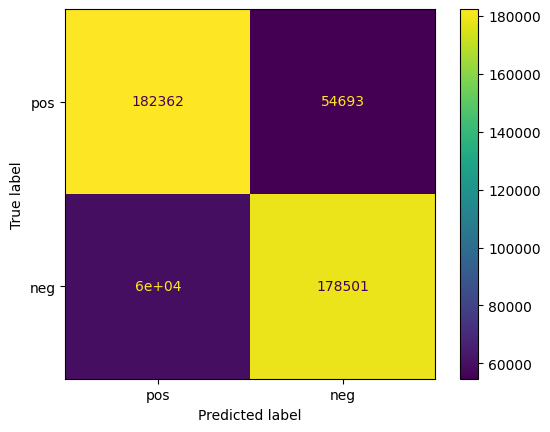

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [105]:
model_result(MultinomialNB(),X_train, Y_train, X_test, Y_test)

In [108]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm

clfs = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegressionCV(cv=5, random_state=24),
    svm.SVC(random_state=24),
]

for clf in clfs:
    model_result(clf, X_train, Y_train, X_test, Y_test)

Clf: GaussianNB()
